## This DeepLearning detector uses ResNet 152 That was manually customized for the Stanford Dataset

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May  9 08:32:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
#Importing Libraries 
import numpy as np
import cv2 as cv
import scipy.io
import os
from tqdm import tqdm
import random
import shutil

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
!unzip '/content/drive/MyDrive/Car_Dataset.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/cars_train/cars_train/03145.jpg  
  inflating: /content/cars_train/cars_train/03146.jpg  
  inflating: /content/cars_train/cars_train/03147.jpg  
  inflating: /content/cars_train/cars_train/03148.jpg  
  inflating: /content/cars_train/cars_train/03149.jpg  
  inflating: /content/cars_train/cars_train/03150.jpg  
  inflating: /content/cars_train/cars_train/03151.jpg  
  inflating: /content/cars_train/cars_train/03152.jpg  
  inflating: /content/cars_train/cars_train/03153.jpg  
  inflating: /content/cars_train/cars_train/03154.jpg  
  inflating: /content/cars_train/cars_train/03155.jpg  
  inflating: /content/cars_train/cars_train/03156.jpg  
  inflating: /content/cars_train/cars_train/03157.jpg  
  inflating: /content/cars_train/cars_train/03158.jpg  
  inflating: /content/cars_train/cars_train/03159.jpg  
  inflating: /content/cars_train/cars_train/03160.jpg  
  inflating: /content/cars_train/cars_train/03161.jpg

In [32]:
!mv '/content/cars_test/cars_test' '/content/Cars_Dataset'

In [33]:
!mv '/content/cars_train/cars_train' '/content/Cars_Dataset'

In [34]:
!mv '/content/cars_annos.mat' '/content/Cars_Dataset'

In [9]:
!cp '/content/drive/MyDrive/devkit' -r '/content/'

In [35]:
def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [36]:
def save_train_data(fnames, labels, bboxes):
    src_folder = '/content/Cars_Dataset/cars_train'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    for i in tqdm(range(num_samples)):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))

        if i in train_indexes:
            dst_folder = 'data/train'
        else:
            dst_folder = 'data/valid'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [37]:
def save_test_data(fnames, bboxes):
    src_folder = '/content/Cars_Dataset/cars_test'
    dst_folder = '/content/data/test'
    num_samples = len(fnames)

    for i in tqdm(range(num_samples)):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        if src_image is not None:
            height, width = src_image.shape[:2]
            # margins of 16 pixels
            margin = 16
            x1 = max(0, x1 - margin)
            y1 = max(0, y1 - margin)
            x2 = min(x2 + margin, width)
            y2 = min(y2 + margin, height)
            # print(fname)

            dst_path = os.path.join(dst_folder, fname)
            crop_image = src_image[y1:y2, x1:x2]
            dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
            cv.imwrite(dst_path, dst_img)
        else:
            print(f"Error: could not read image file '{src_path}'")


In [38]:
def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('/content/devkit/cars_train_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)


In [39]:
def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('/content/devkit/cars_test_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []


    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)


In [40]:
if __name__ == '__main__':

    # parameters
    
    img_width, img_height = 224, 224
    cars_meta = scipy.io.loadmat('devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)
    print('class_names.shape: ' + str(class_names.shape))
    print('Sample class_name: [{}]'.format(class_names[8][0][0]))

    ensure_folder('data/train')
    ensure_folder('data/valid')
    ensure_folder('data/test')

    process_train_data()
    process_test_data()

class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]
Processing train data...
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different cars is 196


100%|██████████| 8144/8144 [01:14<00:00, 109.76it/s]


Processing test data...


100%|██████████| 8041/8041 [01:14<00:00, 108.22it/s]


In [41]:
import keras
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [42]:
from keras.layers import Layer
from keras import backend as K
from keras.layers import InputSpec
try:
    from keras import initializations
except ImportError:
    from keras import initializers as initializations

class Scale(Layer):
    '''Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:

        out = in * gamma + beta,

    where 'gamma' and 'beta' are the weights and biases larned.

    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        # Compatibility with TensorFlow >= 1.0.0
        self.gamma = K.variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = K.variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        #self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        #self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self.trainable_parameters = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = K.reshape(self.gamma, broadcast_shape) * x + K.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [43]:
from keras.utils import get_file

# set the weights variable to 'imagenet' and include_top to True
weights = 'imagenet'
include_top = True

# set the cache directory for downloaded files
cache_dir = '/content/models'
WEIGHTS_PATH = 'https://github.com/adamcasson/resnet152/releases/download/v0.1/resnet152_weights_tf.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/adamcasson/resnet152/releases/download/v0.1/resnet152_weights_tf_notop.h5'

# use get_file to download the file locally
weights_path = get_file('resnet152_weights_tf.h5',
                        WEIGHTS_PATH,
                        cache_subdir='models',
                        md5_hash='cdb18a2158b88e392c0905d47dcef965',
                        cache_dir=cache_dir)


243179624/243179624 [==============================] - 2s 0us/step


In [44]:
# -*- coding: utf-8 -*-
from keras import layers
from keras.optimizers import SGD
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
from keras.models import Model
from keras.layers import BatchNormalization

from keras import backend as K

from sklearn.metrics import log_loss

import sys
sys.setrecursionlimit(3000)

def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

    x = Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a', use_bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2a')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
    x = Conv2D(nb_filter2, (kernel_size, kernel_size),
                      name=conv_name_base + '2b', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2b')(x)
    x = Activation('relu', name=conv_name_base + '2b_relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2c')(x)

    x = add([x, input_tensor], name='res' + str(stage) + block)
    x = Activation('relu', name='res' + str(stage) + block + '_relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

    x = Conv2D(nb_filter1, (1, 1), strides=strides,
                      name=conv_name_base + '2a', use_bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2a')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
    x = Conv2D(nb_filter2, (kernel_size, kernel_size),
                      name=conv_name_base + '2b', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2b')(x)
    x = Activation('relu', name=conv_name_base + '2b_relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2c')(x)

    shortcut = Conv2D(nb_filter3, (1, 1), strides=strides,
                             name=conv_name_base + '1', use_bias=False)(input_tensor)
    shortcut = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '1')(shortcut)
    shortcut = Scale(axis=bn_axis, name=scale_name_base + '1')(shortcut)

    x = add([x, shortcut], name='res' + str(stage) + block)
    x = Activation('relu', name='res' + str(stage) + block + '_relu')(x)
    return x

def resnet152_model(img_rows, img_cols, color_type=1, num_classes=None):
    """
    Resnet 152 Model for Keras

    Model Schema and layer naming follow that of the original Caffe implementation
    https://github.com/KaimingHe/deep-residual-networks

    ImageNet Pretrained Weights 
    Theano: https://drive.google.com/file/d/0Byy2AcGyEVxfZHhUT3lWVWxRN28/view?usp=sharing
    TensorFlow: https://drive.google.com/file/d/0Byy2AcGyEVxfeXExMzNNOHpEODg/view?usp=sharing

    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of class labels for our classification task
    """
    eps = 1.1e-5

    # Handle Dimension Ordering for different backends
    global bn_axis
    if K.image_data_format() == 'channels_last':
      bn_axis = 3
      img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    else:	# Must be channels_first
      bn_axis = 1
      img_input = Input(shape=(color_type, img_rows, img_cols), name='data')

    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name='bn_conv1')(x)
    x = Scale(axis=bn_axis, name='scale_conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)
    
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for i in range(1,8):
      x = identity_block(x, 3, [128, 128, 512], stage=3, block='b'+str(i))

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(1,36):
      x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b'+str(i))

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x_fc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(1000, activation='softmax', name='fc1000')(x_fc)

    model = Model(img_input, x_fc)
    if K.image_data_format() == 'channels_first':
      # Use pre-trained weights for Theano backend
      weights_path = '/content/models/models/resnet152_weights_tf.h5'
    else:
      # Use pre-trained weights for Tensorflow backend
      weights_path = '/content/models/models/resnet152_weights_tf.h5'
  
    model.load_weights(weights_path, by_name=True)
    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_newfc = Flatten()(x_newfc)
    x_newfc = Dense(num_classes, activation='softmax', name='fc8')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [45]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

img_width, img_height = 224, 224
num_channels = 3
train_data = 'data/train'
valid_data = 'data/valid'
num_classes = 196
num_train_samples = 6515
num_valid_samples = 1629
verbose = 1
batch_size = 10
num_epochs = 17
patience = 50

if __name__ == '__main__':
    # build a classifier model
    model = resnet152_model(img_height, img_width, num_channels, num_classes)

    # prepare data augmentation configuration
    train_data_gen = ImageDataGenerator(rotation_range=20.,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True)
    valid_data_gen = ImageDataGenerator()

    # callbacks
    tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
    log_file_path = 'logs/training.log'
    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_accuracy', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=int(patience / 4), verbose=1)
    trained_models_path = 'models/model'
    model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_accuracy', verbose=1, save_best_only=True)
    callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]

    #Regenerate batches
    def generate_batches(generator):
      while True:
        for batch in generator:
            yield batch

    # generators
    train_generator = train_data_gen.flow_from_directory(train_data, (img_width, img_height),
                                                     batch_size=batch_size, class_mode='categorical')
    valid_generator = valid_data_gen.flow_from_directory(valid_data, (img_width, img_height),
                                                     batch_size=batch_size, class_mode='categorical')

    train_batches = generate_batches(train_generator)
    valid_batches = generate_batches(valid_generator)

    # fit the model
    model.fit(
        train_batches,
        steps_per_epoch=num_train_samples // batch_size,
        validation_data=valid_batches,
        validation_steps=num_valid_samples // batch_size,
        epochs=num_epochs,
        callbacks=callbacks,
        verbose=verbose)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 8065 images belonging to 196 classes.
Found 3916 images belonging to 196 classes.
Epoch 1/17
651/651 [==============================] - ETA: 0s - loss: 4.0954 - accuracy: 0.1594
Epoch 1: val_accuracy improved from -inf to 0.46790, saving model to models/model.01-0.47.hdf5
651/651 [==============================] - 297s 396ms/step - loss: 4.0954 - accuracy: 0.1594 - val_loss: 2.1331 - val_accuracy: 0.4679 - lr: 0.0010
Epoch 2/17
651/651 [==============================] - ETA: 0s - loss: 1.7494 - accuracy: 0.5603
Epoch 2: val_accuracy improved from 0.46790 to 0.74321, saving model to models/model.02-0.74.hdf5
651/651 [==============================] - 256s 394ms/step - loss: 1.7494 - accuracy: 0.5603 - val_loss: 0.9181 - val_accuracy: 0.7432 - lr: 0.0010
Epoch 3/17
651/651 [==============================] - ETA: 0s - loss: 0.9639 - accuracy: 0.7502
Epoch 3: val_accuracy improved from 0.74321 to 0.88552, saving model to models/model.03-0.89.hdf5
651/651 [============================

In [61]:
#Copying the most accurate model
!cp '/content/models/model.15-0.99.hdf5' -r '/content/drive/MyDrive'

In [60]:
!cp '/content/models/models/resnet152_weights_tf.h5' -r '/content/drive/MyDrive'

In [62]:
!cp '/content/logs' -r '/content/drive/MyDrive'

In [48]:
#Testing the model
import cv2 as cv

def load_model():
    model_weights_path = '/content/models/model.15-0.99.hdf5'
    img_width, img_height = 224, 224
    num_channels = 3
    num_classes = 196
    model = resnet152_model(img_height, img_width, num_channels, num_classes)
    model.load_weights(model_weights_path, by_name=True)
    return model


def draw_str(dst, target, s):
    x, y = target
    cv.putText(dst, s, (x + 1, y + 1), cv.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness=2, lineType=cv.LINE_AA)
    cv.putText(dst, s, (x, y), cv.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv.LINE_AA)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def decode_predictions(preds, top=5):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_names[i], pred[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results

def predict(img_dir, model):
    img_files = []
    for root, dirs, files in os.walk(img_dir, topdown=False):
        for name in files:
            img_files.append(os.path.join(root, name))
    img_files = sorted(img_files)

    y_pred = []
    y_test = []

    for img_path in tqdm(img_files):
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        preds = model.predict(x[None, :, :, :])
        decoded = decode_predictions(preds, top=1)
        pred_label = decoded[0][0][0]
        y_pred.append(pred_label)
        tokens = img_path.split(os.sep)
        if len(tokens) >= 3:
            class_id = int(tokens[-2])
            y_test.append(class_id)

    return y_pred, y_test

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def calc_acc(y_pred, y_test):
    num_corrects = 0
    for i in range(len(y_pred)):
        pred = y_pred[i]
        test = y_test[i]
        if pred == test:
            num_corrects += 1
    return num_corrects / len(y_pred)

if __name__ == '__main__':
    img_width, img_height = 224, 224
    num_channels = 3
    num_classes = 196
    class_names = range(1, (num_classes + 1))
    num_samples = 1629

    print("\nLoad the trained ResNet model....")
    model = load_model()

    y_pred, y_test = predict('data/valid', model)
    print("y_pred: " + str(y_pred))
    print("y_test: " + str(y_test))

    acc = calc_acc(y_pred, y_test)
    print("%s: %.2f%%" % ('acc', acc * 100))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()



acc: 99.26%


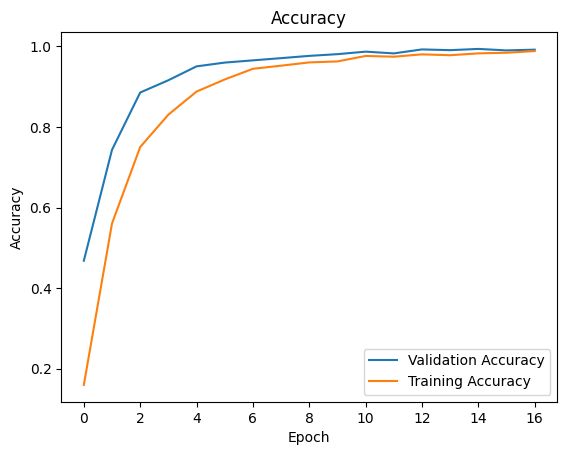

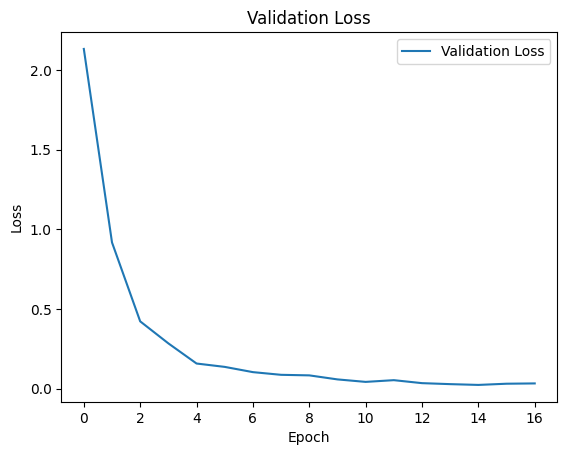

In [67]:
#Accuracies and the Graph
acc = calc_acc(y_pred, y_test)
print("%s: %.2f%%" % ('acc', acc * 100))

import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
logs = pd.read_csv('logs/training.log')

# Plot validation accuracy
plt.plot(logs['val_accuracy'], label='Validation Accuracy')
plt.plot(logs['accuracy'], label='Training Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot validation loss
plt.plot(logs['val_loss'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
!pip install console_progressbar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for console_progressbar: filename=console_progressbar-1.1.2-py3-none-any.whl size=4159 sha256=9d6b382bfdf018bc066eb46a35f90ffcbf543b0460d4bb5a844b104e6e1ed93d
  Stored in directory: /root/.cache/pip/wheels/6d/a2/80/866844b39881baca065cabbf62c3c564a2eba8a88090cc11f0
Successfully built console_progressbar


In [ ]:
import os
import time

import cv2 as cv
import keras.backend as K
import numpy as np
from console_progressbar import ProgressBar

if __name__ == '__main__':
  
    model = load_model()

    pb = ProgressBar(total=100, prefix='Predicting test data', suffix='', decimals=3, length=50, fill='=')
    num_samples = 8041
    start = time.time()
    out = open('result.txt', 'a')
    for i in range(num_samples):
        filename = os.path.join('data/test', '%05d.jpg' % (i + 1))
        bgr_img = cv.imread(filename)
        rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
        rgb_img = np.expand_dims(rgb_img, 0)
        preds = model.predict(rgb_img)
        prob = np.max(preds)
        class_id = np.argmax(preds)
        out.write('{}\n'.format(str(class_id + 1)))
        pb.print_progress_bar((i + 1) * 100 / num_samples)

    end = time.time()
    seconds = end - start
    print('avg fps: {}'.format(str(num_samples / seconds)))

    out.close()
    K.clear_session()


In [ ]:
import json
import os
import random

import cv2 as cv
import keras.backend as K
import numpy as np
import scipy.io


if __name__ == '__main__':
    img_width, img_height = 224, 224
    model = load_model()
    model.load_weights('/content/models/model.15-0.99.hdf5')

    cars_meta = scipy.io.loadmat('devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)

    test_path = 'data/test/'
    test_images = [f for f in os.listdir(test_path) if
                   os.path.isfile(os.path.join(test_path, f)) and f.endswith('.jpg')]

    num_samples = 20
    samples = random.sample(test_images, num_samples)
    results = []
    for i, image_name in enumerate(samples):
        filename = os.path.join(test_path, image_name)
        print('Start processing image: {}'.format(filename))
        bgr_img = cv.imread(filename)
        bgr_img = cv.resize(bgr_img, (img_width, img_height), cv.INTER_CUBIC)
        rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
        rgb_img = np.expand_dims(rgb_img, 0)
        preds = model.predict(rgb_img)
        prob = np.max(preds)
        class_id = np.argmax(preds)
        label = class_names[class_id][0][0]
        text = f'Predict: {label}, prob: {prob:.4f}'
        results.append({'label': label, 'prob': '{:.4f}'.format(prob)})
        # add predicted text to the image
        cv.putText(bgr_img, text, (10, img_height-10), cv.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv.LINE_AA)
        cv.imwrite('/content/images/{}_out.png'.format(i), bgr_img)

    print(results)
    with open('results.json', 'w') as file:
        json.dump(results, file, indent=4)

    K.clear_session()


In [68]:
!cp '/content/result.txt' -r '/content/drive/MyDrive'
!cp '/content/results.json' -r '/content/drive/MyDrive'
!cp '/content/images' -r '/content/drive/MyDrive'

In [69]:
from keras.utils import plot_model


if __name__ == '__main__':
    model = load_model()
    plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.417223 to fit



In [71]:
!cp '/content/model.png' -r '/content/drive/MyDrive'